Convolutional Dictionary Learning with Spatial Mask
===================================================

This example demonstrates the use of [cbpdndl.ConvBPDNMaskDcplDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNMaskDcplDictLearn) for convolutional dictionary learning with a spatial mask, from a set of greyscale training images. The dictionary learning algorithm is based on the hybrid mask decoupling / ADMM consensus dictionary update [[15]](http://sporco.rtfd.org/en/latest/zreferences.html#garcia-2017-convolutional).

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import numpy as np

from sporco.admm import tvl2
from sporco.admm import cbpdndl
from sporco import util
from sporco import plot
plot.config_notebook_plotting()

Load training images.

In [2]:
exim = util.ExampleImages(scaled=True, zoom=0.25, gray=True)
S1 = exim.image('barbara.png', idxexp=np.s_[10:522, 100:612])
S2 = exim.image('kodim23.png', idxexp=np.s_[:, 60:572])
S = np.dstack((S1, S2))

Construct initial dictionary.

In [3]:
np.random.seed(12345)
D0 = np.random.randn(8, 8, 32)

Create random mask and apply to training images.

In [4]:
t = 0.5
W = np.random.randn(*(S.shape[0:2] + (1,)))
W[np.abs(W) > t] = 1;
W[np.abs(W) < t] = 0;
Sw = W * S

:math:`\ell_2`-TV denoising with a spatial mask as a non-linear lowpass
filter.

In [5]:
lmbda = 0.1
opt = tvl2.TVL2Denoise.Options({'Verbose': False, 'MaxMainIter': 200,
            'DFidWeight': W, 'gEvalY': False, 'AutoRho': {'Enabled': True}})
b = tvl2.TVL2Denoise(Sw, lmbda, opt)
sl = b.solve()
sh = Sw - sl

CDL without a spatial mask using [admm.cbpdndl.ConvBPDNDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNDictLearn).

In [6]:
lmbda = 0.05
opt1 = cbpdndl.ConvBPDNDictLearn.Options({'Verbose': True,
            'MaxMainIter': 200, 'AccurateDFid': True,
            'CBPDN': {'rho': 50.0*lmbda + 0.5},
            'CCMOD': {'ZeroMean': True}})
d1 = cbpdndl.ConvBPDNDictLearn(D0, sh, lmbda, opt1)
D1 = d1.solve()

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D       
--------------------------------------------------------------------------------------------------------


   0  9.88e+02  9.07e+02  1.62e+03  8.17e-16  6.72e-01  4.62e-01  3.00e+00  8.33e-01  2.18e-02  1.00e+00


   1  7.91e+02  5.77e+02  4.28e+03  9.87e-16  3.14e-01  6.35e-01  3.00e+00  5.45e-01  1.53e-02  1.00e+00
   2  7.62e+02  5.57e+02  4.10e+03  1.08e-15  2.40e-01  3.87e-01  3.00e+00  5.97e-01  1.19e-02  1.00e+00


   3  7.20e+02  5.61e+02  3.17e+03  1.10e-15  1.82e-01  3.59e-01  3.00e+00  5.88e-01  9.96e-03  1.00e+00


   4  7.13e+02  5.61e+02  3.03e+03  1.04e-15  1.44e-01  2.21e-01  3.00e+00  4.65e-01  8.02e-03  1.00e+00


   5  7.06e+02  5.47e+02  3.19e+03  9.56e-16  1.04e-01  1.90e-01  3.00e+00  4.41e-01  6.32e-03  1.00e+00
   6  7.03e+02  5.40e+02  3.27e+03  1.01e-15  8.20e-02  1.70e-01  3.00e+00  4.06e-01  5.16e-03  1.00e+00


   7  7.00e+02  5.40e+02  3.20e+03  1.10e-15  6.79e-02  1.51e-01  3.00e+00  3.97e-01  4.35e-03  1.00e+00
   8  6.98e+02  5.43e+02  3.10e+03  1.03e-15  5.67e-02  1.37e-01  3.00e+00  3.97e-01  3.76e-03  1.00e+00


   9  6.96e+02  5.44e+02  3.05e+03  1.14e-15  4.80e-02  1.24e-01  3.00e+00  3.52e-01  3.26e-03  1.00e+00
  10  6.95e+02  5.42e+02  3.04e+03  1.13e-15  4.09e-02  1.12e-01  3.00e+00  3.31e-01  2.86e-03  1.00e+00


  11  6.93e+02  5.41e+02  3.05e+03  1.17e-15  3.54e-02  1.05e-01  3.00e+00  3.35e-01  2.54e-03  1.00e+00
  12  6.92e+02  5.40e+02  3.05e+03  1.10e-15  3.12e-02  9.88e-02  3.00e+00  3.24e-01  2.29e-03  1.00e+00


  13  6.91e+02  5.40e+02  3.03e+03  1.07e-15  2.79e-02  9.31e-02  3.00e+00  3.13e-01  2.07e-03  1.00e+00


  14  6.91e+02  5.40e+02  3.01e+03  9.83e-16  2.51e-02  8.82e-02  3.00e+00  3.10e-01  1.87e-03  1.00e+00
  15  6.90e+02  5.40e+02  3.00e+03  1.00e-15  2.28e-02  8.33e-02  3.00e+00  3.03e-01  1.70e-03  1.00e+00


  16  6.89e+02  5.40e+02  2.99e+03  8.04e-16  2.09e-02  7.92e-02  3.00e+00  3.06e-01  1.55e-03  1.00e+00
  17  6.89e+02  5.39e+02  2.99e+03  9.91e-16  1.94e-02  7.57e-02  3.00e+00  3.05e-01  1.42e-03  1.00e+00


  18  6.88e+02  5.39e+02  2.98e+03  1.02e-15  1.80e-02  7.26e-02  3.00e+00  2.97e-01  1.31e-03  1.00e+00
  19  6.88e+02  5.39e+02  2.97e+03  1.07e-15  1.69e-02  6.98e-02  3.00e+00  2.92e-01  1.22e-03  1.00e+00


  20  6.87e+02  5.39e+02  2.97e+03  1.08e-15  1.59e-02  6.72e-02  3.00e+00  2.94e-01  1.13e-03  1.00e+00
  21  6.87e+02  5.39e+02  2.96e+03  1.19e-15  1.51e-02  6.50e-02  3.00e+00  2.90e-01  1.06e-03  1.00e+00


  22  6.86e+02  5.39e+02  2.95e+03  1.03e-15  1.43e-02  6.27e-02  3.00e+00  2.86e-01  9.95e-04  1.00e+00
  23  6.86e+02  5.38e+02  2.95e+03  9.39e-16  1.36e-02  6.07e-02  3.00e+00  2.80e-01  9.36e-04  1.00e+00


  24  6.85e+02  5.38e+02  2.95e+03  1.07e-15  1.31e-02  5.88e-02  3.00e+00  2.74e-01  8.84e-04  1.00e+00
  25  6.85e+02  5.38e+02  2.94e+03  9.73e-16  1.25e-02  5.71e-02  3.00e+00  2.67e-01  8.37e-04  1.00e+00


  26  6.85e+02  5.38e+02  2.94e+03  1.04e-15  1.20e-02  5.56e-02  3.00e+00  2.61e-01  7.94e-04  1.00e+00
  27  6.85e+02  5.38e+02  2.93e+03  1.14e-15  1.16e-02  5.41e-02  3.00e+00  2.57e-01  7.55e-04  1.00e+00


  28  6.84e+02  5.38e+02  2.93e+03  9.84e-16  1.12e-02  5.27e-02  3.00e+00  2.54e-01  7.18e-04  1.00e+00
  29  6.84e+02  5.38e+02  2.93e+03  1.08e-15  1.08e-02  5.14e-02  3.00e+00  2.49e-01  6.82e-04  1.00e+00


  30  6.84e+02  5.38e+02  2.92e+03  1.20e-15  1.04e-02  5.01e-02  3.00e+00  2.44e-01  6.48e-04  1.00e+00


  31  6.83e+02  5.37e+02  2.92e+03  9.49e-16  1.01e-02  4.89e-02  3.00e+00  2.41e-01  6.17e-04  1.00e+00
  32  6.83e+02  5.37e+02  2.92e+03  1.12e-15  9.77e-03  4.78e-02  3.00e+00  2.38e-01  5.89e-04  1.00e+00


  33  6.83e+02  5.37e+02  2.91e+03  1.19e-15  9.48e-03  4.67e-02  3.00e+00  2.35e-01  5.63e-04  1.00e+00


  34  6.83e+02  5.37e+02  2.91e+03  9.20e-16  9.19e-03  4.57e-02  3.00e+00  2.32e-01  5.38e-04  1.00e+00
  35  6.83e+02  5.37e+02  2.91e+03  1.06e-15  8.94e-03  4.48e-02  3.00e+00  2.31e-01  5.15e-04  1.00e+00


  36  6.82e+02  5.37e+02  2.91e+03  1.08e-15  8.71e-03  4.39e-02  3.00e+00  2.29e-01  4.95e-04  1.00e+00
  37  6.82e+02  5.37e+02  2.90e+03  1.04e-15  8.50e-03  4.31e-02  3.00e+00  2.27e-01  4.76e-04  1.00e+00


  38  6.82e+02  5.37e+02  2.90e+03  1.15e-15  8.28e-03  4.23e-02  3.00e+00  2.25e-01  4.59e-04  1.00e+00
  39  6.82e+02  5.37e+02  2.90e+03  9.55e-16  8.08e-03  4.15e-02  3.00e+00  2.23e-01  4.43e-04  1.00e+00


  40  6.82e+02  5.37e+02  2.90e+03  1.01e-15  7.89e-03  4.08e-02  3.00e+00  2.23e-01  4.27e-04  1.00e+00


  41  6.82e+02  5.37e+02  2.90e+03  1.14e-15  7.72e-03  4.02e-02  3.00e+00  2.24e-01  4.13e-04  1.00e+00


  42  6.81e+02  5.37e+02  2.89e+03  1.20e-15  7.55e-03  3.95e-02  3.00e+00  2.26e-01  4.00e-04  1.00e+00


  43  6.81e+02  5.37e+02  2.89e+03  1.23e-15  7.39e-03  3.89e-02  3.00e+00  2.27e-01  3.87e-04  1.00e+00


  44  6.81e+02  5.37e+02  2.89e+03  1.23e-15  7.25e-03  3.83e-02  3.00e+00  2.29e-01  3.74e-04  1.00e+00
  45  6.81e+02  5.37e+02  2.89e+03  1.11e-15  7.11e-03  3.78e-02  3.00e+00  2.28e-01  3.62e-04  1.00e+00


  46  6.81e+02  5.37e+02  2.89e+03  1.22e-15  6.98e-03  3.73e-02  3.00e+00  2.25e-01  3.51e-04  1.00e+00


  47  6.81e+02  5.36e+02  2.88e+03  1.26e-15  6.85e-03  3.68e-02  3.00e+00  2.25e-01  3.42e-04  1.00e+00


  48  6.81e+02  5.36e+02  2.88e+03  9.76e-16  6.74e-03  3.63e-02  3.00e+00  2.24e-01  3.32e-04  1.00e+00


  49  6.80e+02  5.36e+02  2.88e+03  1.23e-15  6.62e-03  3.59e-02  3.00e+00  2.25e-01  3.23e-04  1.00e+00


  50  6.80e+02  5.36e+02  2.88e+03  1.02e-15  6.52e-03  3.54e-02  3.00e+00  2.27e-01  3.15e-04  1.00e+00
  51  6.80e+02  5.36e+02  2.88e+03  1.22e-15  6.41e-03  3.50e-02  3.00e+00  2.26e-01  3.07e-04  1.00e+00


  52  6.80e+02  5.36e+02  2.88e+03  1.29e-15  6.31e-03  3.47e-02  3.00e+00  2.24e-01  3.00e-04  1.00e+00


  53  6.80e+02  5.36e+02  2.87e+03  1.08e-15  6.21e-03  3.43e-02  3.00e+00  2.24e-01  2.93e-04  1.00e+00


  54  6.80e+02  5.36e+02  2.87e+03  1.02e-15  6.13e-03  3.39e-02  3.00e+00  2.24e-01  2.86e-04  1.00e+00


  55  6.80e+02  5.36e+02  2.87e+03  9.47e-16  6.04e-03  3.35e-02  3.00e+00  2.22e-01  2.79e-04  1.00e+00


  56  6.80e+02  5.36e+02  2.87e+03  1.15e-15  5.96e-03  3.31e-02  3.00e+00  2.21e-01  2.73e-04  1.00e+00


  57  6.80e+02  5.36e+02  2.87e+03  9.89e-16  5.88e-03  3.28e-02  3.00e+00  2.18e-01  2.67e-04  1.00e+00


  58  6.79e+02  5.36e+02  2.87e+03  1.12e-15  5.80e-03  3.24e-02  3.00e+00  2.17e-01  2.60e-04  1.00e+00


  59  6.79e+02  5.36e+02  2.87e+03  1.28e-15  5.72e-03  3.20e-02  3.00e+00  2.13e-01  2.54e-04  1.00e+00


  60  6.79e+02  5.36e+02  2.87e+03  1.24e-15  5.64e-03  3.17e-02  3.00e+00  2.09e-01  2.48e-04  1.00e+00


  61  6.79e+02  5.36e+02  2.86e+03  8.40e-16  5.57e-03  3.14e-02  3.00e+00  2.07e-01  2.43e-04  1.00e+00


  62  6.79e+02  5.36e+02  2.86e+03  1.11e-15  5.50e-03  3.11e-02  3.00e+00  2.05e-01  2.38e-04  1.00e+00


  63  6.79e+02  5.36e+02  2.86e+03  1.03e-15  5.43e-03  3.08e-02  3.00e+00  2.05e-01  2.33e-04  1.00e+00


  64  6.79e+02  5.36e+02  2.86e+03  1.26e-15  5.37e-03  3.05e-02  3.00e+00  2.03e-01  2.28e-04  1.00e+00


  65  6.79e+02  5.36e+02  2.86e+03  1.16e-15  5.30e-03  3.02e-02  3.00e+00  2.01e-01  2.24e-04  1.00e+00


  66  6.79e+02  5.36e+02  2.86e+03  1.32e-15  5.25e-03  3.00e-02  3.00e+00  2.00e-01  2.19e-04  1.00e+00


  67  6.79e+02  5.36e+02  2.86e+03  1.14e-15  5.18e-03  2.97e-02  3.00e+00  1.99e-01  2.15e-04  1.00e+00


  68  6.79e+02  5.36e+02  2.86e+03  1.25e-15  5.13e-03  2.95e-02  3.00e+00  1.99e-01  2.11e-04  1.00e+00


  69  6.78e+02  5.36e+02  2.86e+03  9.79e-16  5.08e-03  2.93e-02  3.00e+00  1.99e-01  2.08e-04  1.00e+00


  70  6.78e+02  5.36e+02  2.85e+03  1.09e-15  5.03e-03  2.90e-02  3.00e+00  1.97e-01  2.04e-04  1.00e+00


  71  6.78e+02  5.36e+02  2.85e+03  1.03e-15  4.98e-03  2.88e-02  3.00e+00  1.97e-01  2.01e-04  1.00e+00


  72  6.78e+02  5.36e+02  2.85e+03  1.29e-15  4.93e-03  2.86e-02  3.00e+00  1.97e-01  1.97e-04  1.00e+00


  73  6.78e+02  5.36e+02  2.85e+03  1.20e-15  4.88e-03  2.84e-02  3.00e+00  1.97e-01  1.94e-04  1.00e+00


  74  6.78e+02  5.36e+02  2.85e+03  1.00e-15  4.84e-03  2.82e-02  3.00e+00  1.96e-01  1.91e-04  1.00e+00


  75  6.78e+02  5.36e+02  2.85e+03  9.62e-16  4.80e-03  2.80e-02  3.00e+00  1.95e-01  1.87e-04  1.00e+00


  76  6.78e+02  5.36e+02  2.85e+03  1.17e-15  4.76e-03  2.78e-02  3.00e+00  1.95e-01  1.84e-04  1.00e+00


  77  6.78e+02  5.35e+02  2.85e+03  1.20e-15  4.71e-03  2.76e-02  3.00e+00  1.94e-01  1.81e-04  1.00e+00
  78  6.78e+02  5.35e+02  2.85e+03  1.13e-15  4.67e-03  2.74e-02  3.00e+00  1.94e-01  1.78e-04  1.00e+00


  79  6.78e+02  5.35e+02  2.85e+03  1.26e-15  4.63e-03  2.72e-02  3.00e+00  1.93e-01  1.75e-04  1.00e+00


  80  6.78e+02  5.35e+02  2.85e+03  1.18e-15  4.59e-03  2.70e-02  3.00e+00  1.91e-01  1.72e-04  1.00e+00


  81  6.78e+02  5.35e+02  2.85e+03  1.11e-15  4.55e-03  2.68e-02  3.00e+00  1.90e-01  1.69e-04  1.00e+00
  82  6.78e+02  5.35e+02  2.84e+03  1.22e-15  4.52e-03  2.66e-02  3.00e+00  1.89e-01  1.66e-04  1.00e+00


  83  6.78e+02  5.35e+02  2.84e+03  1.21e-15  4.48e-03  2.64e-02  3.00e+00  1.88e-01  1.64e-04  1.00e+00
  84  6.77e+02  5.35e+02  2.84e+03  1.15e-15  4.44e-03  2.62e-02  3.00e+00  1.88e-01  1.61e-04  1.00e+00


  85  6.77e+02  5.35e+02  2.84e+03  1.34e-15  4.40e-03  2.61e-02  3.00e+00  1.87e-01  1.58e-04  1.00e+00


  86  6.77e+02  5.35e+02  2.84e+03  1.11e-15  4.37e-03  2.59e-02  3.00e+00  1.87e-01  1.56e-04  1.00e+00


  87  6.77e+02  5.35e+02  2.84e+03  1.29e-15  4.34e-03  2.57e-02  3.00e+00  1.89e-01  1.54e-04  1.00e+00


  88  6.77e+02  5.35e+02  2.84e+03  1.34e-15  4.31e-03  2.56e-02  3.00e+00  1.89e-01  1.51e-04  1.00e+00


  89  6.77e+02  5.35e+02  2.84e+03  1.23e-15  4.27e-03  2.55e-02  3.00e+00  1.89e-01  1.49e-04  1.00e+00


  90  6.77e+02  5.35e+02  2.84e+03  1.17e-15  4.24e-03  2.53e-02  3.00e+00  1.91e-01  1.48e-04  1.00e+00


  91  6.77e+02  5.35e+02  2.84e+03  1.31e-15  4.21e-03  2.52e-02  3.00e+00  1.92e-01  1.46e-04  1.00e+00


  92  6.77e+02  5.35e+02  2.84e+03  1.19e-15  4.18e-03  2.51e-02  3.00e+00  1.90e-01  1.44e-04  1.00e+00


  93  6.77e+02  5.35e+02  2.84e+03  1.29e-15  4.16e-03  2.50e-02  3.00e+00  1.90e-01  1.42e-04  1.00e+00
  94  6.77e+02  5.35e+02  2.84e+03  1.04e-15  4.13e-03  2.48e-02  3.00e+00  1.91e-01  1.41e-04  1.00e+00


  95  6.77e+02  5.35e+02  2.83e+03  1.23e-15  4.11e-03  2.47e-02  3.00e+00  1.89e-01  1.39e-04  1.00e+00


  96  6.77e+02  5.35e+02  2.83e+03  1.01e-15  4.08e-03  2.46e-02  3.00e+00  1.90e-01  1.37e-04  1.00e+00


  97  6.77e+02  5.35e+02  2.83e+03  1.14e-15  4.06e-03  2.45e-02  3.00e+00  1.90e-01  1.36e-04  1.00e+00
  98  6.77e+02  5.35e+02  2.83e+03  1.19e-15  4.04e-03  2.43e-02  3.00e+00  1.87e-01  1.34e-04  1.00e+00


  99  6.77e+02  5.35e+02  2.83e+03  1.29e-15  4.01e-03  2.42e-02  3.00e+00  1.88e-01  1.33e-04  1.00e+00


 100  6.77e+02  5.35e+02  2.83e+03  1.21e-15  3.99e-03  2.41e-02  3.00e+00  1.88e-01  1.31e-04  1.00e+00


 101  6.77e+02  5.35e+02  2.83e+03  1.33e-15  3.96e-03  2.40e-02  3.00e+00  1.89e-01  1.29e-04  1.00e+00


 102  6.76e+02  5.35e+02  2.83e+03  1.37e-15  3.94e-03  2.39e-02  3.00e+00  1.90e-01  1.28e-04  1.00e+00


 103  6.76e+02  5.35e+02  2.83e+03  1.11e-15  3.92e-03  2.38e-02  3.00e+00  1.90e-01  1.26e-04  1.00e+00


 104  6.76e+02  5.35e+02  2.83e+03  1.28e-15  3.90e-03  2.37e-02  3.00e+00  1.89e-01  1.25e-04  1.00e+00


 105  6.76e+02  5.35e+02  2.83e+03  1.12e-15  3.88e-03  2.36e-02  3.00e+00  1.90e-01  1.23e-04  1.00e+00


 106  6.76e+02  5.35e+02  2.83e+03  1.12e-15  3.85e-03  2.35e-02  3.00e+00  1.90e-01  1.22e-04  1.00e+00


 107  6.76e+02  5.35e+02  2.83e+03  1.26e-15  3.84e-03  2.34e-02  3.00e+00  1.90e-01  1.21e-04  1.00e+00


 108  6.76e+02  5.35e+02  2.83e+03  1.10e-15  3.81e-03  2.33e-02  3.00e+00  1.91e-01  1.19e-04  1.00e+00


 109  6.76e+02  5.35e+02  2.83e+03  1.03e-15  3.80e-03  2.32e-02  3.00e+00  1.93e-01  1.18e-04  1.00e+00


 110  6.76e+02  5.35e+02  2.83e+03  1.22e-15  3.77e-03  2.31e-02  3.00e+00  1.91e-01  1.16e-04  1.00e+00


 111  6.76e+02  5.35e+02  2.82e+03  1.54e-15  3.76e-03  2.30e-02  3.00e+00  1.89e-01  1.15e-04  1.00e+00
 112  6.76e+02  5.35e+02  2.82e+03  1.21e-15  3.74e-03  2.29e-02  3.00e+00  1.87e-01  1.14e-04  1.00e+00


 113  6.76e+02  5.35e+02  2.82e+03  1.00e-15  3.72e-03  2.28e-02  3.00e+00  1.83e-01  1.13e-04  1.00e+00
 114  6.76e+02  5.35e+02  2.82e+03  1.20e-15  3.70e-03  2.27e-02  3.00e+00  1.83e-01  1.12e-04  1.00e+00


 115  6.76e+02  5.35e+02  2.82e+03  1.45e-15  3.68e-03  2.26e-02  3.00e+00  1.84e-01  1.10e-04  1.00e+00


 116  6.76e+02  5.35e+02  2.82e+03  1.39e-15  3.66e-03  2.25e-02  3.00e+00  1.84e-01  1.09e-04  1.00e+00


 117  6.76e+02  5.35e+02  2.82e+03  1.39e-15  3.65e-03  2.24e-02  3.00e+00  1.84e-01  1.08e-04  1.00e+00
 118  6.76e+02  5.35e+02  2.82e+03  1.24e-15  3.63e-03  2.23e-02  3.00e+00  1.86e-01  1.07e-04  1.00e+00


 119  6.76e+02  5.35e+02  2.82e+03  1.26e-15  3.61e-03  2.22e-02  3.00e+00  1.87e-01  1.06e-04  1.00e+00
 120  6.76e+02  5.35e+02  2.82e+03  1.45e-15  3.60e-03  2.22e-02  3.00e+00  1.87e-01  1.06e-04  1.00e+00


 121  6.76e+02  5.35e+02  2.82e+03  1.22e-15  3.58e-03  2.21e-02  3.00e+00  1.89e-01  1.05e-04  1.00e+00
 122  6.76e+02  5.35e+02  2.82e+03  1.35e-15  3.56e-03  2.20e-02  3.00e+00  1.91e-01  1.04e-04  1.00e+00


 123  6.76e+02  5.35e+02  2.82e+03  1.46e-15  3.55e-03  2.19e-02  3.00e+00  1.92e-01  1.03e-04  1.00e+00


 124  6.76e+02  5.35e+02  2.82e+03  1.50e-15  3.53e-03  2.19e-02  3.00e+00  1.92e-01  1.02e-04  1.00e+00


 125  6.75e+02  5.35e+02  2.82e+03  1.34e-15  3.52e-03  2.18e-02  3.00e+00  1.94e-01  1.01e-04  1.00e+00


 126  6.75e+02  5.35e+02  2.82e+03  1.08e-15  3.50e-03  2.17e-02  3.00e+00  1.95e-01  1.01e-04  1.00e+00


 127  6.75e+02  5.35e+02  2.82e+03  1.67e-15  3.49e-03  2.17e-02  3.00e+00  1.97e-01  9.98e-05  1.00e+00


 128  6.75e+02  5.35e+02  2.82e+03  1.29e-15  3.47e-03  2.16e-02  3.00e+00  1.96e-01  9.90e-05  1.00e+00


 129  6.75e+02  5.35e+02  2.82e+03  1.41e-15  3.46e-03  2.16e-02  3.00e+00  1.96e-01  9.82e-05  1.00e+00


 130  6.75e+02  5.35e+02  2.81e+03  1.16e-15  3.45e-03  2.15e-02  3.00e+00  1.94e-01  9.75e-05  1.00e+00


 131  6.75e+02  5.35e+02  2.81e+03  1.31e-15  3.44e-03  2.15e-02  3.00e+00  1.95e-01  9.68e-05  1.00e+00


 132  6.75e+02  5.35e+02  2.81e+03  1.25e-15  3.43e-03  2.14e-02  3.00e+00  1.96e-01  9.60e-05  1.00e+00


 133  6.75e+02  5.35e+02  2.81e+03  1.36e-15  3.42e-03  2.14e-02  3.00e+00  1.95e-01  9.53e-05  1.00e+00


 134  6.75e+02  5.35e+02  2.81e+03  1.29e-15  3.41e-03  2.13e-02  3.00e+00  1.96e-01  9.45e-05  1.00e+00


 135  6.75e+02  5.35e+02  2.81e+03  1.30e-15  3.40e-03  2.13e-02  3.00e+00  1.96e-01  9.38e-05  1.00e+00


 136  6.75e+02  5.35e+02  2.81e+03  1.40e-15  3.39e-03  2.12e-02  3.00e+00  1.96e-01  9.31e-05  1.00e+00


 137  6.75e+02  5.34e+02  2.81e+03  1.06e-15  3.38e-03  2.12e-02  3.00e+00  1.94e-01  9.25e-05  1.00e+00
 138  6.75e+02  5.34e+02  2.81e+03  1.34e-15  3.37e-03  2.12e-02  3.00e+00  1.93e-01  9.18e-05  1.00e+00


 139  6.75e+02  5.34e+02  2.81e+03  1.25e-15  3.36e-03  2.11e-02  3.00e+00  1.91e-01  9.10e-05  1.00e+00


 140  6.75e+02  5.34e+02  2.81e+03  1.41e-15  3.35e-03  2.10e-02  3.00e+00  1.92e-01  9.01e-05  1.00e+00


 141  6.75e+02  5.34e+02  2.81e+03  1.33e-15  3.34e-03  2.10e-02  3.00e+00  1.93e-01  8.93e-05  1.00e+00


 142  6.75e+02  5.34e+02  2.81e+03  1.38e-15  3.33e-03  2.09e-02  3.00e+00  1.93e-01  8.84e-05  1.00e+00


 143  6.75e+02  5.34e+02  2.81e+03  9.99e-16  3.32e-03  2.08e-02  3.00e+00  1.93e-01  8.75e-05  1.00e+00


 144  6.75e+02  5.34e+02  2.81e+03  1.13e-15  3.31e-03  2.08e-02  3.00e+00  1.92e-01  8.66e-05  1.00e+00
 145  6.75e+02  5.34e+02  2.81e+03  1.35e-15  3.29e-03  2.07e-02  3.00e+00  1.92e-01  8.56e-05  1.00e+00


 146  6.75e+02  5.34e+02  2.81e+03  1.32e-15  3.28e-03  2.06e-02  3.00e+00  1.92e-01  8.47e-05  1.00e+00


 147  6.75e+02  5.34e+02  2.81e+03  1.24e-15  3.27e-03  2.05e-02  3.00e+00  1.90e-01  8.38e-05  1.00e+00


 148  6.75e+02  5.34e+02  2.81e+03  1.49e-15  3.25e-03  2.04e-02  3.00e+00  1.89e-01  8.30e-05  1.00e+00


 149  6.75e+02  5.34e+02  2.81e+03  1.43e-15  3.24e-03  2.04e-02  3.00e+00  1.89e-01  8.22e-05  1.00e+00


 150  6.75e+02  5.34e+02  2.81e+03  1.39e-15  3.23e-03  2.03e-02  3.00e+00  1.89e-01  8.15e-05  1.00e+00
 151  6.75e+02  5.34e+02  2.80e+03  1.45e-15  3.21e-03  2.03e-02  3.00e+00  1.90e-01  8.07e-05  1.00e+00


 152  6.75e+02  5.34e+02  2.80e+03  1.30e-15  3.20e-03  2.02e-02  3.00e+00  1.91e-01  7.99e-05  1.00e+00
 153  6.75e+02  5.34e+02  2.80e+03  1.27e-15  3.19e-03  2.01e-02  3.00e+00  1.90e-01  7.91e-05  1.00e+00


 154  6.74e+02  5.34e+02  2.80e+03  1.53e-15  3.17e-03  2.01e-02  3.00e+00  1.88e-01  7.85e-05  1.00e+00


 155  6.74e+02  5.34e+02  2.80e+03  1.34e-15  3.16e-03  2.00e-02  3.00e+00  1.86e-01  7.79e-05  1.00e+00


 156  6.74e+02  5.34e+02  2.80e+03  1.37e-15  3.15e-03  1.99e-02  3.00e+00  1.87e-01  7.73e-05  1.00e+00


 157  6.74e+02  5.34e+02  2.80e+03  1.62e-15  3.14e-03  1.99e-02  3.00e+00  1.89e-01  7.67e-05  1.00e+00


 158  6.74e+02  5.34e+02  2.80e+03  1.58e-15  3.13e-03  1.98e-02  3.00e+00  1.88e-01  7.61e-05  1.00e+00


 159  6.74e+02  5.34e+02  2.80e+03  1.20e-15  3.11e-03  1.98e-02  3.00e+00  1.88e-01  7.55e-05  1.00e+00


 160  6.74e+02  5.34e+02  2.80e+03  1.33e-15  3.10e-03  1.97e-02  3.00e+00  1.88e-01  7.49e-05  1.00e+00


 161  6.74e+02  5.34e+02  2.80e+03  1.18e-15  3.09e-03  1.96e-02  3.00e+00  1.89e-01  7.43e-05  1.00e+00


 162  6.74e+02  5.34e+02  2.80e+03  1.16e-15  3.08e-03  1.95e-02  3.00e+00  1.90e-01  7.36e-05  1.00e+00


 163  6.74e+02  5.34e+02  2.80e+03  1.34e-15  3.07e-03  1.95e-02  3.00e+00  1.89e-01  7.30e-05  1.00e+00


 164  6.74e+02  5.34e+02  2.80e+03  1.29e-15  3.06e-03  1.94e-02  3.00e+00  1.87e-01  7.24e-05  1.00e+00


 165  6.74e+02  5.34e+02  2.80e+03  1.17e-15  3.04e-03  1.94e-02  3.00e+00  1.87e-01  7.18e-05  1.00e+00


 166  6.74e+02  5.34e+02  2.80e+03  1.58e-15  3.03e-03  1.93e-02  3.00e+00  1.88e-01  7.11e-05  1.00e+00


 167  6.74e+02  5.34e+02  2.80e+03  1.08e-15  3.02e-03  1.92e-02  3.00e+00  1.87e-01  7.05e-05  1.00e+00


 168  6.74e+02  5.34e+02  2.80e+03  1.44e-15  3.01e-03  1.92e-02  3.00e+00  1.87e-01  6.98e-05  1.00e+00


 169  6.74e+02  5.34e+02  2.80e+03  1.55e-15  3.00e-03  1.91e-02  3.00e+00  1.88e-01  6.93e-05  1.00e+00


 170  6.74e+02  5.34e+02  2.80e+03  1.36e-15  2.99e-03  1.90e-02  3.00e+00  1.87e-01  6.87e-05  1.00e+00


 171  6.74e+02  5.34e+02  2.80e+03  1.41e-15  2.97e-03  1.90e-02  3.00e+00  1.87e-01  6.81e-05  1.00e+00


 172  6.74e+02  5.34e+02  2.80e+03  1.39e-15  2.96e-03  1.89e-02  3.00e+00  1.86e-01  6.75e-05  1.00e+00


 173  6.74e+02  5.34e+02  2.80e+03  1.74e-15  2.95e-03  1.88e-02  3.00e+00  1.85e-01  6.69e-05  1.00e+00


 174  6.74e+02  5.34e+02  2.80e+03  1.57e-15  2.94e-03  1.88e-02  3.00e+00  1.86e-01  6.64e-05  1.00e+00


 175  6.74e+02  5.34e+02  2.80e+03  1.94e-15  2.93e-03  1.87e-02  3.00e+00  1.87e-01  6.58e-05  1.00e+00


 176  6.74e+02  5.34e+02  2.79e+03  1.32e-15  2.91e-03  1.86e-02  3.00e+00  1.87e-01  6.53e-05  1.00e+00


 177  6.74e+02  5.34e+02  2.79e+03  1.80e-15  2.90e-03  1.86e-02  3.00e+00  1.86e-01  6.48e-05  1.00e+00


 178  6.74e+02  5.34e+02  2.79e+03  1.35e-15  2.89e-03  1.85e-02  3.00e+00  1.86e-01  6.43e-05  1.00e+00


 179  6.74e+02  5.34e+02  2.79e+03  1.24e-15  2.88e-03  1.85e-02  3.00e+00  1.85e-01  6.38e-05  1.00e+00


 180  6.74e+02  5.34e+02  2.79e+03  1.11e-15  2.87e-03  1.84e-02  3.00e+00  1.85e-01  6.34e-05  1.00e+00


 181  6.74e+02  5.34e+02  2.79e+03  1.34e-15  2.86e-03  1.84e-02  3.00e+00  1.85e-01  6.29e-05  1.00e+00


 182  6.74e+02  5.34e+02  2.79e+03  1.43e-15  2.85e-03  1.83e-02  3.00e+00  1.86e-01  6.24e-05  1.00e+00


 183  6.74e+02  5.34e+02  2.79e+03  1.34e-15  2.84e-03  1.83e-02  3.00e+00  1.87e-01  6.19e-05  1.00e+00


 184  6.74e+02  5.34e+02  2.79e+03  1.60e-15  2.83e-03  1.82e-02  3.00e+00  1.87e-01  6.16e-05  1.00e+00
 185  6.74e+02  5.34e+02  2.79e+03  1.24e-15  2.82e-03  1.82e-02  3.00e+00  1.85e-01  6.12e-05  1.00e+00


 186  6.74e+02  5.34e+02  2.79e+03  1.50e-15  2.81e-03  1.81e-02  3.00e+00  1.84e-01  6.09e-05  1.00e+00


 187  6.74e+02  5.34e+02  2.79e+03  1.48e-15  2.80e-03  1.81e-02  3.00e+00  1.84e-01  6.05e-05  1.00e+00


 188  6.74e+02  5.34e+02  2.79e+03  1.28e-15  2.79e-03  1.80e-02  3.00e+00  1.85e-01  6.01e-05  1.00e+00


 189  6.74e+02  5.34e+02  2.79e+03  1.16e-15  2.78e-03  1.79e-02  3.00e+00  1.87e-01  5.97e-05  1.00e+00


 190  6.74e+02  5.34e+02  2.79e+03  1.34e-15  2.77e-03  1.79e-02  3.00e+00  1.87e-01  5.93e-05  1.00e+00


 191  6.73e+02  5.34e+02  2.79e+03  1.31e-15  2.76e-03  1.78e-02  3.00e+00  1.87e-01  5.90e-05  1.00e+00


 192  6.73e+02  5.34e+02  2.79e+03  1.30e-15  2.75e-03  1.78e-02  3.00e+00  1.86e-01  5.86e-05  1.00e+00


 193  6.73e+02  5.34e+02  2.79e+03  1.35e-15  2.74e-03  1.77e-02  3.00e+00  1.83e-01  5.81e-05  1.00e+00


 194  6.73e+02  5.34e+02  2.79e+03  1.40e-15  2.73e-03  1.77e-02  3.00e+00  1.81e-01  5.76e-05  1.00e+00


 195  6.73e+02  5.34e+02  2.79e+03  1.35e-15  2.72e-03  1.76e-02  3.00e+00  1.80e-01  5.72e-05  1.00e+00


 196  6.73e+02  5.34e+02  2.79e+03  1.49e-15  2.72e-03  1.75e-02  3.00e+00  1.79e-01  5.68e-05  1.00e+00


 197  6.73e+02  5.34e+02  2.79e+03  1.39e-15  2.71e-03  1.75e-02  3.00e+00  1.81e-01  5.65e-05  1.00e+00


 198  6.73e+02  5.34e+02  2.79e+03  1.37e-15  2.70e-03  1.75e-02  3.00e+00  1.82e-01  5.62e-05  1.00e+00


 199  6.73e+02  5.34e+02  2.79e+03  1.51e-15  2.69e-03  1.74e-02  3.00e+00  1.82e-01  5.59e-05  1.00e+00
--------------------------------------------------------------------------------------------------------


Reconstruct from the CDL solution without a spatial mask.

In [7]:
sr1 = d1.reconstruct().squeeze() + sl

CDL with a spatial mask using [cbpdndl.ConvBPDNMaskDcplDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNMaskDcplDictLearn).

In [8]:
opt2 = cbpdndl.ConvBPDNMaskDcplDictLearn.Options({'Verbose': True,
            'MaxMainIter': 200, 'AccurateDFid': True,
            'CBPDN': {'rho': 50.0*lmbda + 0.5},
            'CCMOD': {'ZeroMean': True}})
d2 = cbpdndl.ConvBPDNMaskDcplDictLearn(D0, sh, lmbda, W, opt2)
D2 = d2.solve()

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D       
--------------------------------------------------------------------------------------------------------


   0  2.45e+02  1.22e+02  2.46e+03  9.70e-16  3.50e-01  3.02e+00  3.00e+00  1.47e-01  1.20e+00  1.00e+00


   1  3.33e+02  1.85e+02  2.95e+03  8.75e-16  1.50e-01  1.81e+00  3.00e+00  8.98e-02  1.17e+00  1.00e+00


   2  2.11e+02  1.08e+02  2.05e+03  9.11e-16  1.14e-01  2.36e+00  3.00e+00  1.11e-01  1.06e+00  1.00e+00


   3  1.13e+02  5.04e+01  1.25e+03  1.18e-15  6.41e-02  1.62e+00  3.00e+00  1.57e-01  1.05e+00  1.00e+00


   4  7.38e+01  3.10e+01  8.55e+02  9.79e-16  5.62e-02  1.56e+00  3.00e+00  1.60e-01  1.06e+00  1.00e+00


   5  5.66e+01  2.13e+01  7.06e+02  1.08e-15  4.08e-02  1.12e+00  3.00e+00  1.62e-01  1.05e+00  1.00e+00


   6  4.66e+01  1.45e+01  6.42e+02  9.31e-16  3.56e-02  9.47e-01  3.00e+00  1.58e-01  1.03e+00  1.00e+00


   7  3.92e+01  1.02e+01  5.79e+02  9.37e-16  2.98e-02  7.53e-01  3.00e+00  1.67e-01  1.01e+00  1.00e+00


   8  3.36e+01  8.35e+00  5.05e+02  9.78e-16  2.58e-02  6.35e-01  3.00e+00  1.63e-01  9.95e-01  1.00e+00


   9  3.00e+01  7.82e+00  4.44e+02  9.85e-16  2.24e-02  5.38e-01  3.00e+00  1.50e-01  9.77e-01  1.00e+00


  10  2.78e+01  7.41e+00  4.08e+02  1.07e-15  1.97e-02  4.83e-01  3.00e+00  1.35e-01  9.47e-01  1.00e+00


  11  2.64e+01  6.78e+00  3.92e+02  8.17e-16  1.76e-02  4.43e-01  3.00e+00  1.27e-01  8.75e-01  1.00e+00


  12  2.53e+01  6.17e+00  3.83e+02  1.14e-15  1.58e-02  4.13e-01  3.00e+00  1.19e-01  7.16e-01  1.00e+00


  13  2.45e+01  5.79e+00  3.73e+02  8.48e-16  1.44e-02  3.89e-01  3.00e+00  1.08e-01  6.44e-01  1.00e+00
  14  2.37e+01  5.71e+00  3.60e+02  1.08e-15  1.34e-02  3.67e-01  3.00e+00  9.19e-02  7.63e-01  1.00e+00


  15  2.32e+01  5.81e+00  3.48e+02  1.00e-15  1.26e-02  3.47e-01  3.00e+00  7.54e-02  8.31e-01  1.00e+00
  16  2.28e+01  5.91e+00  3.38e+02  9.14e-16  1.20e-02  3.28e-01  3.00e+00  6.81e-02  8.52e-01  1.00e+00


  17  2.25e+01  5.87e+00  3.33e+02  9.57e-16  1.14e-02  3.14e-01  3.00e+00  7.27e-02  8.49e-01  1.00e+00


  18  2.22e+01  5.72e+00  3.30e+02  1.12e-15  1.08e-02  3.07e-01  3.00e+00  7.58e-02  8.33e-01  1.00e+00


  19  2.20e+01  5.54e+00  3.29e+02  8.05e-16  1.03e-02  3.04e-01  3.00e+00  7.09e-02  8.14e-01  1.00e+00
  20  2.18e+01  5.38e+00  3.28e+02  8.36e-16  9.78e-03  3.04e-01  3.00e+00  6.14e-02  7.92e-01  1.00e+00


  21  2.16e+01  5.27e+00  3.26e+02  8.21e-16  9.34e-03  3.02e-01  3.00e+00  5.41e-02  7.54e-01  1.00e+00
  22  2.14e+01  5.20e+00  3.24e+02  1.07e-15  8.94e-03  2.96e-01  3.00e+00  5.30e-02  6.82e-01  1.00e+00


  23  2.12e+01  5.15e+00  3.21e+02  1.02e-15  8.61e-03  2.86e-01  3.00e+00  5.49e-02  5.63e-01  1.00e+00


  24  2.10e+01  5.11e+00  3.18e+02  9.85e-16  8.32e-03  2.72e-01  3.00e+00  5.55e-02  4.26e-01  1.00e+00


  25  2.08e+01  5.06e+00  3.15e+02  8.87e-16  8.08e-03  2.58e-01  3.00e+00  5.23e-02  3.90e-01  1.00e+00


  26  2.07e+01  5.02e+00  3.13e+02  1.06e-15  7.88e-03  2.46e-01  3.00e+00  4.63e-02  4.71e-01  1.00e+00


  27  2.06e+01  5.01e+00  3.11e+02  8.98e-16  7.69e-03  2.40e-01  3.00e+00  3.85e-02  5.58e-01  1.00e+00


  28  2.05e+01  5.02e+00  3.09e+02  9.65e-16  7.49e-03  2.39e-01  3.00e+00  3.03e-02  6.14e-01  1.00e+00


  29  2.04e+01  5.04e+00  3.07e+02  8.56e-16  7.28e-03  2.42e-01  3.00e+00  2.40e-02  6.37e-01  1.00e+00


  30  2.03e+01  5.06e+00  3.05e+02  1.05e-15  7.06e-03  2.44e-01  3.00e+00  2.13e-02  6.35e-01  1.00e+00


  31  2.02e+01  5.04e+00  3.04e+02  8.57e-16  6.85e-03  2.44e-01  3.00e+00  2.23e-02  6.10e-01  1.00e+00


  32  2.02e+01  4.99e+00  3.03e+02  9.21e-16  6.66e-03  2.39e-01  3.00e+00  2.46e-02  5.63e-01  1.00e+00


  33  2.01e+01  4.93e+00  3.03e+02  8.53e-16  6.50e-03  2.31e-01  3.00e+00  2.69e-02  4.95e-01  1.00e+00


  34  2.00e+01  4.87e+00  3.03e+02  1.08e-15  6.38e-03  2.20e-01  3.00e+00  2.82e-02  4.10e-01  1.00e+00


  35  2.00e+01  4.83e+00  3.02e+02  1.10e-15  6.27e-03  2.10e-01  3.00e+00  2.85e-02  3.23e-01  1.00e+00


  36  1.99e+01  4.81e+00  3.02e+02  9.37e-16  6.15e-03  2.03e-01  3.00e+00  2.79e-02  2.64e-01  1.00e+00


  37  1.98e+01  4.80e+00  3.01e+02  9.30e-16  6.03e-03  2.01e-01  3.00e+00  2.65e-02  2.62e-01  1.00e+00


  38  1.98e+01  4.79e+00  3.00e+02  9.54e-16  5.90e-03  2.03e-01  3.00e+00  2.42e-02  3.05e-01  1.00e+00


  39  1.97e+01  4.77e+00  2.99e+02  9.17e-16  5.77e-03  2.05e-01  3.00e+00  2.13e-02  3.56e-01  1.00e+00


  40  1.97e+01  4.75e+00  2.99e+02  8.80e-16  5.65e-03  2.06e-01  3.00e+00  1.82e-02  3.96e-01  1.00e+00


  41  1.97e+01  4.73e+00  2.98e+02  9.39e-16  5.55e-03  2.04e-01  3.00e+00  1.53e-02  4.19e-01  1.00e+00


  42  1.96e+01  4.72e+00  2.98e+02  1.13e-15  5.46e-03  2.00e-01  3.00e+00  1.35e-02  4.24e-01  1.00e+00


  43  1.96e+01  4.72e+00  2.97e+02  1.37e-15  5.38e-03  1.94e-01  3.00e+00  1.33e-02  4.11e-01  1.00e+00


  44  1.95e+01  4.73e+00  2.96e+02  1.05e-15  5.29e-03  1.88e-01  3.00e+00  1.43e-02  3.83e-01  1.00e+00


  45  1.95e+01  4.74e+00  2.95e+02  1.20e-15  5.20e-03  1.83e-01  3.00e+00  1.59e-02  3.41e-01  1.00e+00


  46  1.95e+01  4.75e+00  2.94e+02  1.21e-15  5.10e-03  1.80e-01  3.00e+00  1.73e-02  2.91e-01  1.00e+00


  47  1.94e+01  4.75e+00  2.94e+02  9.82e-16  4.99e-03  1.79e-01  3.00e+00  1.82e-02  2.41e-01  1.00e+00


  48  1.94e+01  4.74e+00  2.93e+02  1.10e-15  4.89e-03  1.79e-01  3.00e+00  1.84e-02  2.00e-01  1.00e+00


  49  1.94e+01  4.73e+00  2.93e+02  9.92e-16  4.80e-03  1.78e-01  3.00e+00  1.78e-02  1.83e-01  1.00e+00


  50  1.93e+01  4.71e+00  2.92e+02  1.14e-15  4.73e-03  1.76e-01  3.00e+00  1.67e-02  1.91e-01  1.00e+00


  51  1.93e+01  4.70e+00  2.92e+02  1.04e-15  4.66e-03  1.72e-01  3.00e+00  1.52e-02  2.14e-01  1.00e+00


  52  1.93e+01  4.69e+00  2.92e+02  9.07e-16  4.61e-03  1.68e-01  3.00e+00  1.35e-02  2.38e-01  1.00e+00


  53  1.92e+01  4.69e+00  2.91e+02  1.11e-15  4.55e-03  1.64e-01  3.00e+00  1.19e-02  2.58e-01  1.00e+00


  54  1.92e+01  4.69e+00  2.91e+02  1.05e-15  4.48e-03  1.61e-01  3.00e+00  1.05e-02  2.69e-01  1.00e+00


  55  1.92e+01  4.68e+00  2.90e+02  9.82e-16  4.40e-03  1.60e-01  3.00e+00  9.75e-03  2.70e-01  1.00e+00


  56  1.92e+01  4.67e+00  2.90e+02  1.09e-15  4.32e-03  1.58e-01  3.00e+00  9.65e-03  2.62e-01  1.00e+00


  57  1.92e+01  4.65e+00  2.90e+02  9.75e-16  4.24e-03  1.57e-01  3.00e+00  1.00e-02  2.45e-01  1.00e+00


  58  1.91e+01  4.63e+00  2.90e+02  9.18e-16  4.16e-03  1.56e-01  3.00e+00  1.06e-02  2.22e-01  1.00e+00


  59  1.91e+01  4.61e+00  2.90e+02  1.17e-15  4.10e-03  1.54e-01  3.00e+00  1.11e-02  1.95e-01  1.00e+00


  60  1.91e+01  4.60e+00  2.90e+02  9.34e-16  4.04e-03  1.51e-01  3.00e+00  1.15e-02  1.69e-01  1.00e+00


  61  1.91e+01  4.59e+00  2.90e+02  8.63e-16  3.98e-03  1.48e-01  3.00e+00  1.16e-02  1.48e-01  1.00e+00


  62  1.91e+01  4.59e+00  2.89e+02  1.13e-15  3.93e-03  1.45e-01  3.00e+00  1.14e-02  1.37e-01  1.00e+00


  63  1.90e+01  4.60e+00  2.89e+02  9.89e-16  3.88e-03  1.43e-01  3.00e+00  1.09e-02  1.37e-01  1.00e+00


  64  1.90e+01  4.60e+00  2.88e+02  9.72e-16  3.82e-03  1.41e-01  3.00e+00  1.02e-02  1.44e-01  1.00e+00


  65  1.90e+01  4.61e+00  2.88e+02  9.26e-16  3.76e-03  1.40e-01  3.00e+00  9.43e-03  1.55e-01  1.00e+00


  66  1.90e+01  4.61e+00  2.88e+02  9.37e-16  3.71e-03  1.39e-01  3.00e+00  8.63e-03  1.66e-01  1.00e+00


  67  1.90e+01  4.61e+00  2.87e+02  1.00e-15  3.65e-03  1.37e-01  3.00e+00  7.94e-03  1.72e-01  1.00e+00


  68  1.90e+01  4.61e+00  2.87e+02  1.03e-15  3.60e-03  1.36e-01  3.00e+00  7.44e-03  1.74e-01  1.00e+00


  69  1.89e+01  4.60e+00  2.87e+02  9.43e-16  3.55e-03  1.34e-01  3.00e+00  7.22e-03  1.72e-01  1.00e+00


  70  1.89e+01  4.59e+00  2.87e+02  9.10e-16  3.50e-03  1.31e-01  3.00e+00  7.24e-03  1.64e-01  1.00e+00


  71  1.89e+01  4.58e+00  2.87e+02  8.09e-16  3.46e-03  1.29e-01  3.00e+00  7.42e-03  1.53e-01  1.00e+00


  72  1.89e+01  4.58e+00  2.86e+02  9.17e-16  3.41e-03  1.27e-01  3.00e+00  7.66e-03  1.40e-01  1.00e+00


  73  1.89e+01  4.57e+00  2.86e+02  1.00e-15  3.36e-03  1.26e-01  3.00e+00  7.86e-03  1.26e-01  1.00e+00


  74  1.89e+01  4.57e+00  2.86e+02  9.73e-16  3.32e-03  1.24e-01  3.00e+00  7.98e-03  1.13e-01  1.00e+00


  75  1.89e+01  4.57e+00  2.86e+02  9.96e-16  3.27e-03  1.23e-01  3.00e+00  7.95e-03  1.03e-01  1.00e+00


  76  1.88e+01  4.56e+00  2.86e+02  1.19e-15  3.23e-03  1.22e-01  3.00e+00  7.79e-03  9.86e-02  1.00e+00


  77  1.88e+01  4.56e+00  2.85e+02  7.84e-16  3.19e-03  1.21e-01  3.00e+00  7.50e-03  9.85e-02  1.00e+00


  78  1.88e+01  4.55e+00  2.85e+02  1.05e-15  3.14e-03  1.19e-01  3.00e+00  7.13e-03  1.02e-01  1.00e+00


  79  1.88e+01  4.55e+00  2.85e+02  1.10e-15  3.10e-03  1.17e-01  3.00e+00  6.72e-03  1.06e-01  1.00e+00


  80  1.88e+01  4.55e+00  2.85e+02  1.05e-15  3.07e-03  1.16e-01  3.00e+00  6.32e-03  1.11e-01  1.00e+00


  81  1.88e+01  4.55e+00  2.85e+02  1.20e-15  3.03e-03  1.14e-01  3.00e+00  5.97e-03  1.14e-01  1.00e+00


  82  1.88e+01  4.55e+00  2.84e+02  1.19e-15  2.99e-03  1.12e-01  3.00e+00  5.71e-03  1.15e-01  1.00e+00


  83  1.88e+01  4.55e+00  2.84e+02  8.59e-16  2.95e-03  1.11e-01  3.00e+00  5.57e-03  1.13e-01  1.00e+00


  84  1.87e+01  4.55e+00  2.84e+02  1.09e-15  2.91e-03  1.10e-01  3.00e+00  5.52e-03  1.09e-01  1.00e+00


  85  1.87e+01  4.54e+00  2.84e+02  1.07e-15  2.87e-03  1.09e-01  3.00e+00  5.55e-03  1.03e-01  1.00e+00


  86  1.87e+01  4.54e+00  2.84e+02  8.12e-16  2.83e-03  1.07e-01  3.00e+00  5.62e-03  9.63e-02  1.00e+00


  87  1.87e+01  4.54e+00  2.84e+02  9.91e-16  2.79e-03  1.06e-01  3.00e+00  5.67e-03  8.89e-02  1.00e+00


  88  1.87e+01  4.53e+00  2.83e+02  9.72e-16  2.76e-03  1.05e-01  3.00e+00  5.70e-03  8.19e-02  1.00e+00


  89  1.87e+01  4.52e+00  2.83e+02  1.06e-15  2.72e-03  1.03e-01  3.00e+00  5.68e-03  7.63e-02  1.00e+00


  90  1.87e+01  4.52e+00  2.83e+02  8.51e-16  2.69e-03  1.02e-01  3.00e+00  5.61e-03  7.27e-02  1.00e+00


  91  1.87e+01  4.51e+00  2.83e+02  1.10e-15  2.66e-03  1.00e-01  3.00e+00  5.49e-03  7.13e-02  1.00e+00


  92  1.87e+01  4.51e+00  2.83e+02  1.04e-15  2.63e-03  9.91e-02  3.00e+00  5.32e-03  7.17e-02  1.00e+00


  93  1.87e+01  4.50e+00  2.83e+02  1.09e-15  2.59e-03  9.81e-02  3.00e+00  5.12e-03  7.33e-02  1.00e+00


  94  1.86e+01  4.50e+00  2.83e+02  9.14e-16  2.56e-03  9.71e-02  3.00e+00  4.92e-03  7.52e-02  1.00e+00


  95  1.86e+01  4.50e+00  2.83e+02  9.70e-16  2.53e-03  9.60e-02  3.00e+00  4.73e-03  7.67e-02  1.00e+00


  96  1.86e+01  4.50e+00  2.82e+02  8.05e-16  2.50e-03  9.48e-02  3.00e+00  4.57e-03  7.74e-02  1.00e+00


  97  1.86e+01  4.50e+00  2.82e+02  1.09e-15  2.47e-03  9.36e-02  3.00e+00  4.43e-03  7.69e-02  1.00e+00


  98  1.86e+01  4.50e+00  2.82e+02  9.94e-16  2.44e-03  9.23e-02  3.00e+00  4.36e-03  7.52e-02  1.00e+00


  99  1.86e+01  4.50e+00  2.82e+02  8.75e-16  2.41e-03  9.12e-02  3.00e+00  4.34e-03  7.24e-02  1.00e+00


 100  1.86e+01  4.50e+00  2.82e+02  1.20e-15  2.38e-03  9.03e-02  3.00e+00  4.35e-03  6.88e-02  1.00e+00


 101  1.86e+01  4.50e+00  2.82e+02  9.48e-16  2.35e-03  8.94e-02  3.00e+00  4.37e-03  6.47e-02  1.00e+00


 102  1.86e+01  4.50e+00  2.81e+02  9.99e-16  2.32e-03  8.85e-02  3.00e+00  4.39e-03  6.05e-02  1.00e+00


 103  1.86e+01  4.50e+00  2.81e+02  8.96e-16  2.29e-03  8.76e-02  3.00e+00  4.39e-03  5.68e-02  1.00e+00


 104  1.86e+01  4.49e+00  2.81e+02  1.09e-15  2.27e-03  8.65e-02  3.00e+00  4.36e-03  5.39e-02  1.00e+00


 105  1.85e+01  4.49e+00  2.81e+02  1.07e-15  2.24e-03  8.52e-02  3.00e+00  4.30e-03  5.20e-02  1.00e+00


 106  1.85e+01  4.48e+00  2.81e+02  1.05e-15  2.22e-03  8.40e-02  3.00e+00  4.21e-03  5.13e-02  1.00e+00


 107  1.85e+01  4.47e+00  2.81e+02  7.20e-16  2.19e-03  8.29e-02  3.00e+00  4.11e-03  5.14e-02  1.00e+00


 108  1.85e+01  4.46e+00  2.81e+02  9.64e-16  2.17e-03  8.20e-02  3.00e+00  4.01e-03  5.19e-02  1.00e+00


 109  1.85e+01  4.46e+00  2.81e+02  9.75e-16  2.14e-03  8.12e-02  3.00e+00  3.91e-03  5.27e-02  1.00e+00


 110  1.85e+01  4.46e+00  2.81e+02  9.81e-16  2.12e-03  8.05e-02  3.00e+00  3.80e-03  5.33e-02  1.00e+00


 111  1.85e+01  4.47e+00  2.81e+02  1.06e-15  2.09e-03  7.98e-02  3.00e+00  3.71e-03  5.34e-02  1.00e+00


 112  1.85e+01  4.46e+00  2.81e+02  9.75e-16  2.07e-03  7.89e-02  3.00e+00  3.63e-03  5.31e-02  1.00e+00


 113  1.85e+01  4.46e+00  2.80e+02  8.64e-16  2.04e-03  7.79e-02  3.00e+00  3.59e-03  5.21e-02  1.00e+00


 114  1.85e+01  4.46e+00  2.80e+02  1.24e-15  2.02e-03  7.68e-02  3.00e+00  3.56e-03  5.05e-02  1.00e+00


 115  1.85e+01  4.45e+00  2.80e+02  1.09e-15  2.00e-03  7.57e-02  3.00e+00  3.54e-03  4.85e-02  1.00e+00


 116  1.85e+01  4.45e+00  2.80e+02  1.20e-15  1.97e-03  7.47e-02  3.00e+00  3.54e-03  4.62e-02  1.00e+00


 117  1.85e+01  4.45e+00  2.80e+02  1.05e-15  1.95e-03  7.38e-02  3.00e+00  3.53e-03  4.38e-02  1.00e+00


 118  1.85e+01  4.45e+00  2.80e+02  1.01e-15  1.93e-03  7.30e-02  3.00e+00  3.52e-03  4.16e-02  1.00e+00


 119  1.84e+01  4.45e+00  2.80e+02  9.29e-16  1.91e-03  7.24e-02  3.00e+00  3.50e-03  3.97e-02  1.00e+00


 120  1.84e+01  4.45e+00  2.80e+02  8.53e-16  1.89e-03  7.18e-02  3.00e+00  3.46e-03  3.84e-02  1.00e+00


 121  1.84e+01  4.45e+00  2.80e+02  8.27e-16  1.86e-03  7.12e-02  3.00e+00  3.41e-03  3.77e-02  1.00e+00


 122  1.84e+01  4.45e+00  2.79e+02  1.08e-15  1.84e-03  7.05e-02  3.00e+00  3.35e-03  3.75e-02  1.00e+00


 123  1.84e+01  4.45e+00  2.79e+02  1.12e-15  1.82e-03  6.96e-02  3.00e+00  3.29e-03  3.77e-02  1.00e+00


 124  1.84e+01  4.45e+00  2.79e+02  1.01e-15  1.80e-03  6.87e-02  3.00e+00  3.22e-03  3.80e-02  1.00e+00


 125  1.84e+01  4.44e+00  2.79e+02  1.03e-15  1.78e-03  6.78e-02  3.00e+00  3.15e-03  3.82e-02  1.00e+00


 126  1.84e+01  4.44e+00  2.79e+02  1.01e-15  1.76e-03  6.69e-02  3.00e+00  3.10e-03  3.83e-02  1.00e+00


 127  1.84e+01  4.44e+00  2.79e+02  1.15e-15  1.74e-03  6.61e-02  3.00e+00  3.05e-03  3.80e-02  1.00e+00


 128  1.84e+01  4.43e+00  2.79e+02  1.13e-15  1.72e-03  6.54e-02  3.00e+00  3.00e-03  3.74e-02  1.00e+00


 129  1.84e+01  4.43e+00  2.79e+02  9.14e-16  1.70e-03  6.47e-02  3.00e+00  2.96e-03  3.64e-02  1.00e+00


 130  1.84e+01  4.43e+00  2.79e+02  8.98e-16  1.68e-03  6.41e-02  3.00e+00  2.94e-03  3.52e-02  1.00e+00


 131  1.84e+01  4.43e+00  2.79e+02  1.08e-15  1.66e-03  6.35e-02  3.00e+00  2.93e-03  3.39e-02  1.00e+00


 132  1.84e+01  4.43e+00  2.79e+02  9.25e-16  1.65e-03  6.29e-02  3.00e+00  2.91e-03  3.24e-02  1.00e+00


 133  1.84e+01  4.43e+00  2.79e+02  1.11e-15  1.63e-03  6.23e-02  3.00e+00  2.89e-03  3.11e-02  1.00e+00


 134  1.84e+01  4.43e+00  2.79e+02  1.08e-15  1.61e-03  6.16e-02  3.00e+00  2.88e-03  2.99e-02  1.00e+00


 135  1.84e+01  4.43e+00  2.78e+02  1.09e-15  1.59e-03  6.08e-02  3.00e+00  2.85e-03  2.89e-02  1.00e+00


 136  1.83e+01  4.43e+00  2.78e+02  1.07e-15  1.58e-03  6.00e-02  3.00e+00  2.82e-03  2.82e-02  1.00e+00


 137  1.83e+01  4.43e+00  2.78e+02  1.06e-15  1.56e-03  5.93e-02  3.00e+00  2.78e-03  2.79e-02  1.00e+00


 138  1.83e+01  4.43e+00  2.78e+02  1.17e-15  1.54e-03  5.86e-02  3.00e+00  2.74e-03  2.77e-02  1.00e+00


 139  1.83e+01  4.43e+00  2.78e+02  1.10e-15  1.53e-03  5.80e-02  3.00e+00  2.71e-03  2.78e-02  1.00e+00


 140  1.83e+01  4.43e+00  2.78e+02  1.09e-15  1.51e-03  5.74e-02  3.00e+00  2.67e-03  2.78e-02  1.00e+00


 141  1.83e+01  4.43e+00  2.78e+02  1.06e-15  1.49e-03  5.68e-02  3.00e+00  2.64e-03  2.79e-02  1.00e+00


 142  1.83e+01  4.43e+00  2.78e+02  8.97e-16  1.47e-03  5.61e-02  3.00e+00  2.61e-03  2.78e-02  1.00e+00


 143  1.83e+01  4.42e+00  2.78e+02  1.11e-15  1.46e-03  5.53e-02  3.00e+00  2.58e-03  2.75e-02  1.00e+00


 144  1.83e+01  4.42e+00  2.78e+02  1.01e-15  1.44e-03  5.46e-02  3.00e+00  2.56e-03  2.71e-02  1.00e+00


 145  1.83e+01  4.42e+00  2.78e+02  1.02e-15  1.43e-03  5.39e-02  3.00e+00  2.54e-03  2.64e-02  1.00e+00


 146  1.83e+01  4.42e+00  2.78e+02  1.05e-15  1.41e-03  5.34e-02  3.00e+00  2.53e-03  2.56e-02  1.00e+00


 147  1.83e+01  4.41e+00  2.78e+02  9.15e-16  1.40e-03  5.29e-02  3.00e+00  2.51e-03  2.47e-02  1.00e+00


 148  1.83e+01  4.41e+00  2.78e+02  9.95e-16  1.38e-03  5.26e-02  3.00e+00  2.49e-03  2.38e-02  1.00e+00


 149  1.83e+01  4.41e+00  2.77e+02  1.30e-15  1.37e-03  5.22e-02  3.00e+00  2.47e-03  2.30e-02  1.00e+00


 150  1.83e+01  4.41e+00  2.77e+02  1.06e-15  1.35e-03  5.17e-02  3.00e+00  2.46e-03  2.24e-02  1.00e+00


 151  1.83e+01  4.41e+00  2.77e+02  1.07e-15  1.34e-03  5.11e-02  3.00e+00  2.43e-03  2.19e-02  1.00e+00


 152  1.83e+01  4.41e+00  2.77e+02  8.97e-16  1.32e-03  5.04e-02  3.00e+00  2.40e-03  2.16e-02  1.00e+00


 153  1.83e+01  4.41e+00  2.77e+02  1.05e-15  1.31e-03  4.97e-02  3.00e+00  2.38e-03  2.14e-02  1.00e+00


 154  1.83e+01  4.41e+00  2.77e+02  1.05e-15  1.30e-03  4.91e-02  3.00e+00  2.35e-03  2.13e-02  1.00e+00


 155  1.83e+01  4.40e+00  2.77e+02  1.16e-15  1.28e-03  4.85e-02  3.00e+00  2.33e-03  2.13e-02  1.00e+00


 156  1.83e+01  4.40e+00  2.77e+02  7.71e-16  1.27e-03  4.81e-02  3.00e+00  2.31e-03  2.12e-02  1.00e+00


 157  1.83e+01  4.40e+00  2.77e+02  1.01e-15  1.26e-03  4.77e-02  3.00e+00  2.29e-03  2.10e-02  1.00e+00


 158  1.82e+01  4.40e+00  2.77e+02  1.03e-15  1.24e-03  4.73e-02  3.00e+00  2.28e-03  2.08e-02  1.00e+00


 159  1.82e+01  4.40e+00  2.77e+02  9.07e-16  1.23e-03  4.67e-02  3.00e+00  2.26e-03  2.05e-02  1.00e+00


 160  1.82e+01  4.40e+00  2.77e+02  1.06e-15  1.22e-03  4.60e-02  3.00e+00  2.24e-03  2.01e-02  1.00e+00


 161  1.82e+01  4.40e+00  2.77e+02  1.06e-15  1.20e-03  4.54e-02  3.00e+00  2.22e-03  1.97e-02  1.00e+00


 162  1.82e+01  4.40e+00  2.77e+02  1.11e-15  1.19e-03  4.47e-02  3.00e+00  2.21e-03  1.92e-02  1.00e+00


 163  1.82e+01  4.40e+00  2.77e+02  1.06e-15  1.18e-03  4.42e-02  3.00e+00  2.19e-03  1.87e-02  1.00e+00


 164  1.82e+01  4.40e+00  2.77e+02  1.03e-15  1.17e-03  4.39e-02  3.00e+00  2.18e-03  1.82e-02  1.00e+00


 165  1.82e+01  4.40e+00  2.76e+02  1.02e-15  1.16e-03  4.36e-02  3.00e+00  2.16e-03  1.77e-02  1.00e+00


 166  1.82e+01  4.39e+00  2.76e+02  1.20e-15  1.14e-03  4.34e-02  3.00e+00  2.15e-03  1.73e-02  1.00e+00


 167  1.82e+01  4.39e+00  2.76e+02  1.00e-15  1.13e-03  4.30e-02  3.00e+00  2.14e-03  1.69e-02  1.00e+00


 168  1.82e+01  4.39e+00  2.76e+02  1.07e-15  1.12e-03  4.26e-02  3.00e+00  2.12e-03  1.67e-02  1.00e+00


 169  1.82e+01  4.39e+00  2.76e+02  9.63e-16  1.11e-03  4.21e-02  3.00e+00  2.10e-03  1.66e-02  1.00e+00


 170  1.82e+01  4.39e+00  2.76e+02  9.87e-16  1.10e-03  4.16e-02  3.00e+00  2.08e-03  1.66e-02  1.00e+00


 171  1.82e+01  4.39e+00  2.76e+02  1.15e-15  1.09e-03  4.11e-02  3.00e+00  2.07e-03  1.66e-02  1.00e+00


 172  1.82e+01  4.39e+00  2.76e+02  1.04e-15  1.08e-03  4.07e-02  3.00e+00  2.05e-03  1.66e-02  1.00e+00


 173  1.82e+01  4.39e+00  2.76e+02  1.22e-15  1.07e-03  4.04e-02  3.00e+00  2.03e-03  1.65e-02  1.00e+00


 174  1.82e+01  4.39e+00  2.76e+02  1.07e-15  1.06e-03  4.01e-02  3.00e+00  2.02e-03  1.64e-02  1.00e+00


 175  1.82e+01  4.39e+00  2.76e+02  8.78e-16  1.05e-03  3.97e-02  3.00e+00  2.01e-03  1.62e-02  1.00e+00


 176  1.82e+01  4.39e+00  2.76e+02  9.84e-16  1.04e-03  3.92e-02  3.00e+00  2.00e-03  1.59e-02  1.00e+00


 177  1.82e+01  4.39e+00  2.76e+02  1.18e-15  1.03e-03  3.87e-02  3.00e+00  2.00e-03  1.56e-02  1.00e+00


 178  1.82e+01  4.38e+00  2.76e+02  9.17e-16  1.02e-03  3.82e-02  3.00e+00  1.99e-03  1.53e-02  1.00e+00


 179  1.82e+01  4.38e+00  2.76e+02  8.81e-16  1.01e-03  3.77e-02  3.00e+00  1.98e-03  1.50e-02  1.00e+00


 180  1.82e+01  4.38e+00  2.76e+02  1.13e-15  9.99e-04  3.74e-02  3.00e+00  1.97e-03  1.47e-02  1.00e+00


 181  1.82e+01  4.38e+00  2.76e+02  9.63e-16  9.89e-04  3.72e-02  3.00e+00  1.96e-03  1.44e-02  1.00e+00


 182  1.82e+01  4.38e+00  2.76e+02  9.26e-16  9.79e-04  3.69e-02  3.00e+00  1.94e-03  1.42e-02  1.00e+00


 183  1.82e+01  4.38e+00  2.76e+02  1.01e-15  9.69e-04  3.67e-02  3.00e+00  1.93e-03  1.40e-02  1.00e+00


 184  1.82e+01  4.38e+00  2.76e+02  9.41e-16  9.61e-04  3.63e-02  3.00e+00  1.92e-03  1.39e-02  1.00e+00


 185  1.82e+01  4.37e+00  2.76e+02  1.11e-15  9.53e-04  3.59e-02  3.00e+00  1.92e-03  1.37e-02  1.00e+00


 186  1.81e+01  4.37e+00  2.76e+02  9.60e-16  9.46e-04  3.55e-02  3.00e+00  1.92e-03  1.36e-02  1.00e+00


 187  1.81e+01  4.37e+00  2.75e+02  9.46e-16  9.39e-04  3.51e-02  3.00e+00  1.91e-03  1.35e-02  1.00e+00


 188  1.81e+01  4.37e+00  2.75e+02  1.10e-15  9.32e-04  3.48e-02  3.00e+00  1.91e-03  1.34e-02  1.00e+00


 189  1.81e+01  4.37e+00  2.75e+02  9.33e-16  9.24e-04  3.45e-02  3.00e+00  1.90e-03  1.34e-02  1.00e+00


 190  1.81e+01  4.37e+00  2.75e+02  9.16e-16  9.15e-04  3.43e-02  3.00e+00  1.89e-03  1.33e-02  1.00e+00


 191  1.81e+01  4.37e+00  2.75e+02  9.18e-16  9.06e-04  3.41e-02  3.00e+00  1.88e-03  1.32e-02  1.00e+00


 192  1.81e+01  4.37e+00  2.75e+02  1.04e-15  8.98e-04  3.39e-02  3.00e+00  1.87e-03  1.31e-02  1.00e+00


 193  1.81e+01  4.37e+00  2.75e+02  1.21e-15  8.90e-04  3.35e-02  3.00e+00  1.86e-03  1.29e-02  1.00e+00


 194  1.81e+01  4.37e+00  2.75e+02  9.09e-16  8.82e-04  3.31e-02  3.00e+00  1.86e-03  1.27e-02  1.00e+00


 195  1.81e+01  4.37e+00  2.75e+02  1.07e-15  8.76e-04  3.27e-02  3.00e+00  1.85e-03  1.24e-02  1.00e+00


 196  1.81e+01  4.37e+00  2.75e+02  1.03e-15  8.68e-04  3.23e-02  3.00e+00  1.84e-03  1.22e-02  1.00e+00


 197  1.81e+01  4.37e+00  2.75e+02  1.16e-15  8.61e-04  3.20e-02  3.00e+00  1.83e-03  1.20e-02  1.00e+00


 198  1.81e+01  4.36e+00  2.75e+02  1.03e-15  8.53e-04  3.17e-02  3.00e+00  1.82e-03  1.19e-02  1.00e+00


 199  1.81e+01  4.36e+00  2.75e+02  1.05e-15  8.45e-04  3.15e-02  3.00e+00  1.80e-03  1.18e-02  1.00e+00
--------------------------------------------------------------------------------------------------------


Reconstruct from the CDL solution with a spatial mask.

In [9]:
sr2 = d2.reconstruct().squeeze() + sl

Compare dictionaries.

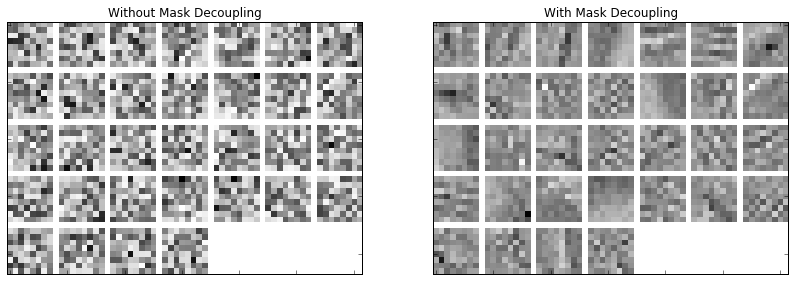

In [10]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D1.squeeze()), fgrf=fig,
            title='Without Mask Decoupling')
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D2.squeeze()), fgrf=fig,
            title='With Mask Decoupling')
fig.show()

Display reference and training images.

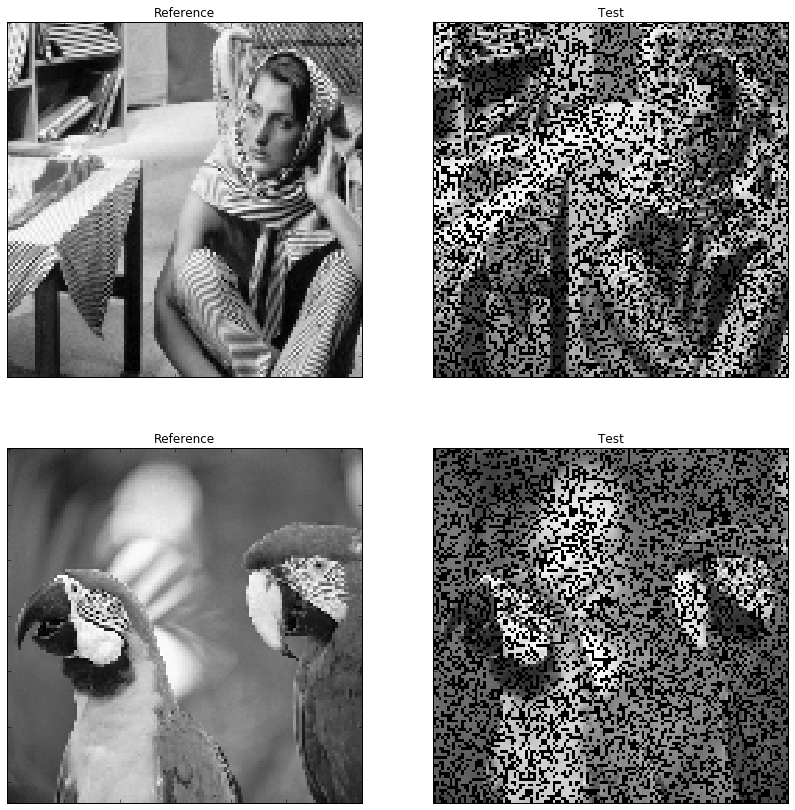

In [11]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(S[...,0], fgrf=fig, title='Reference')
plot.subplot(2, 2, 2)
plot.imview(Sw[...,0], fgrf=fig, title='Test')
plot.subplot(2, 2, 3)
plot.imview(S[...,1], fgrf=fig, title='Reference')
plot.subplot(2, 2, 4)
plot.imview(Sw[...,1], fgrf=fig, title='Test')
fig.show()

Compare reconstructed images.

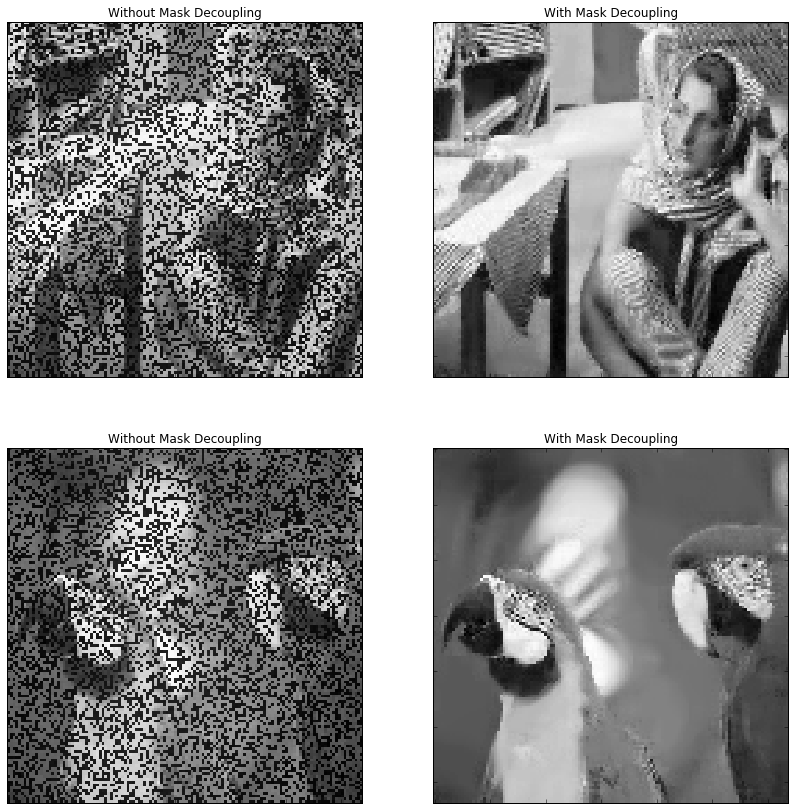

In [12]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(sr1[...,0], fgrf=fig, title='Without Mask Decoupling')
plot.subplot(2, 2, 2)
plot.imview(sr2[...,0], fgrf=fig, title='With Mask Decoupling')
plot.subplot(2, 2, 3)
plot.imview(sr1[...,1], fgrf=fig, title='Without Mask Decoupling')
plot.subplot(2, 2, 4)
plot.imview(sr2[...,1], fgrf=fig, title='With Mask Decoupling')
fig.show()